<a href="https://colab.research.google.com/github/ochekroun/projet-ia/blob/master/classification-images/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -V

In [ ]:
#!pip install -r requirements.txt

In [25]:
!pip install tensorflow==2.16.2
!pip install keras==3.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fou

ERROR: Operation cancelled by user


In [1]:
# utilisons pytorch plutôt que tensorflow
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import keras
from keras import layers
from keras.applications import EfficientNetB0
import requests
import tarfile
import os
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import json
from torch.utils.data import Dataset
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [14]:
!rm -rf ./data/nuswide_81/


In [16]:
download_file = True
if download_file:
    url = 'https://olivierchekroun.blob.core.windows.net/documents/projet-ia/nus_wide.tar.gz'
    file_path = './data/nus_wide.tar.gz'

    # from tqdm import tqdm
    # import requests

    # # Streaming, so we can iterate over the response.
    # response = requests.get(url, stream=True)

    # # Sizes in bytes.
    # total_size = int(response.headers.get("content-length", 0))
    # block_size = 1024

    # with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    #     with open(file_path, "wb") as file:
    #         for data in response.iter_content(block_size):
    #             progress_bar.update(len(data))
    #             file.write(data)

    # if total_size != 0 and progress_bar.n != total_size:
    #     raise RuntimeError("Could not download file")

    # print("Extracting file...")
    # with tarfile.open(name=file_path) as tar:
    #     for member in tqdm(iterable=tar.getmembers(), total=len(tar.getmembers())):
    #         tar.extract(member=member)

    print("Extract images...")
    file = tarfile.open(file_path)
    file.extractall('./data/nuswide_81')
    file.close()

check_image_file = False
if check_image_file:
    image_dir = './data/images'
    bad_image_file_path = './data/bad_images.txt'
    IMG_SIZE = 224
    size = (IMG_SIZE, IMG_SIZE)
    count = 0
    try:
        os.remove(bad_image_file_path)
    except OSError:
        pass
    arr = os.listdir(image_dir)
    print(len(arr))
    bad_files = []
    for image_name in tqdm(arr):
        count += 1
        imagePath = os.path.join(image_dir, image_name)
        try:
            image = Image.open(imagePath)
            image.load()
            image = tf.image.resize(image, size)
            image = image.numpy()
        except Exception as e:
            print(f'{e} {imagePath}')
            bad_files.append(image_name)
            continue
    print(f'Images count: {count}')

    print(bad_files)

    with open(bad_image_file_path, 'w') as f:
        for line in bad_files:
            f.write(f"{line}\n")

Extract images...


In [18]:
def load_labels():
    labels = []
    with open('./data/labels.txt') as f:
        lines = f.read().splitlines()
        for line in lines:
            labels.append(line)
    return labels

def load_dataframe(file_name):
    with open('./data/bad_images.txt', 'r') as file:
        bad_files = file.read().splitlines()

    print(f'Bad files {bad_files}')

    labels = load_labels()

    # Étape 1 : Charger la liste des images

    with open(file_name) as f:
        all_samples_data = f.read().splitlines()


    image_names =[]
    string_values = []
    array_values = []
    given_labels = []
    for data_line in tqdm(all_samples_data):
        parts = data_line.split(' ')
        image_name = parts[0]
        array_value = np.asarray(list(map(int, parts[1:])))
        string_value = ' '.join(parts[1:])

        given_label = np.array(labels)[np.argwhere(array_value)[:, 0]]
        #print(given_labels)

        image_names.append(image_name)
        string_values.append(string_value)
        array_values.append(array_value)
        given_labels.append(given_label)

    # Étape 3 : Créer le DataFrame
    data = {'Image': image_names, 'Values': array_values, 'String_Values': string_values, 'Given_Labels': given_labels}
    df = pd.DataFrame(data)
    print(f'Dataframe length: {len(df)}')

    # Étape 4 : Exclure les lignes où il n'y a que des 0 dans les tableaux de valeurs
    df_filtered = df
    df_filtered = df[df['Values'].apply(lambda x: any(x))]
    df_filtered = df_filtered[~df_filtered['Image'].isin(bad_files)]
    # if stratify :
    #     df_filtered = df_filtered.groupby('String_Values').filter(lambda x: len(x) > 1)
    print(f'Dataframe filtered length: {len(df_filtered)}')

    return df_filtered

In [10]:
df = load_dataframe('./data/database.txt')
labels = load_labels()

Bad files ['164_369098387_98c20067_1306855694.jpg', '65_1306855694_9063340002_b.jpg', '24831_2545048982_3b384d0444_m.jpg']


100%|██████████| 218491/218491 [00:12<00:00, 17779.89it/s]


Dataframe length: 218491
Dataframe filtered length: 169823


In [11]:
%%time
stratify = False
num_class = df['String_Values'].nunique()
print(num_class)
train_size = 5000
val_size = num_class if stratify else int(train_size * 0.2)
test_size = 0.5

if stratify:
    train_df, val_df = train_test_split(
        df,
        stratify = df['String_Values'].values,
        train_size = train_size,
        test_size= val_size
        )
else:
    train_df, val_df = train_test_split(
        df,
        train_size = train_size,
        test_size= val_size
        )

    train_df, test_df = train_test_split(
        train_df,
        test_size = test_size
    )

print("Number of images for training: ", len(train_df))
print("Number of images for validation: ", len(val_df))
print("Number of images for test: ", len(test_df))



# df = load_dataframe('./data/nuswide_81/test.txt')
# num_class = df['String_Values'].nunique()
# print(num_class)
# val_size = num_class if stratify else int(train_size * 0.2)
# if stratify:
#     test_df, _ = train_test_split(
#         df,
#         stratify = df['String_Values'].values,
#         train_size=val_size
#         )
# else:
#     test_df, _ = train_test_split(
#     df,
#     train_size=val_size,
# )
# print("Number of images for test: ", len(test_df))

16249
Number of images for training:  2500
Number of images for validation:  1000
Number of images for test:  2500
CPU times: user 99.9 ms, sys: 588 µs, total: 100 ms
Wall time: 115 ms


In [12]:
def write_df(df, labels, file_path):
    rows = []
    for index, row in test_df[['Image', 'Given_Labels']].iterrows():
        row_image = row['Image']
        row_labels = row['Given_Labels'].tolist()
        row = {'image_name': row_image, 'image_labels': row_labels}
        rows.append(row)
    with open(file_path, 'w') as fp:
        json.dump({'samples': rows, 'labels': labels}, fp, indent=3)

write_df(train_df, labels, './data/train.json')
write_df(val_df, labels, './data/val.json')
write_df(test_df, labels, './data/test.json')

In [3]:
class NusDataset(Dataset):
    def __init__(self, anno_path, transforms = None):
        self.transforms = transforms
        with open(anno_path) as fp:
            json_data = json.load(fp)
        samples = json_data['samples']
        self.classes = json_data['labels']

        self.imgs = []
        self.annos = []
        print('loading', anno_path)
        for sample in samples:
            self.imgs.append(sample['image_name'])
            self.annos.append(sample['image_labels'])
        for item_id in range(len(self.annos)):
            item = self.annos[item_id]
            vector = [cls in item for cls in self.classes]
            self.annos[item_id] = np.array(vector, dtype=float)

    def __getitem__(self, item):
        anno = self.annos[item]
        try:
            IMG_SIZE = 224
            size = (IMG_SIZE, IMG_SIZE)
            img_path = self.imgs[item]
            image = Image.open(img_path)
            if self.transforms is not None:
                image = self.transforms(image)
            # image = tf.image.resize(image, size)
            # image = image.numpy()
        except Exception as e:
            print(f'{e} {img_path}')
        return image, anno

    def __len__(self):
        return len(self.imgs)

In [19]:
!ls ./data/nuswide_81/images/11781_1590858672_d446580056_m.jpg

./data/nuswide_81/images/11781_1590858672_d446580056_m.jpg


loading ./data/test.json


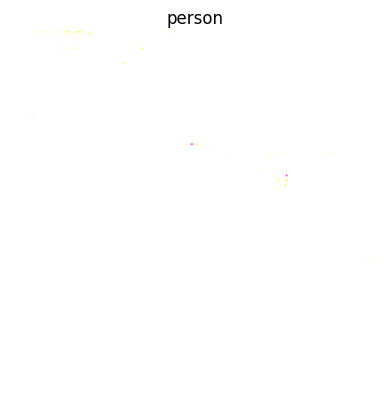

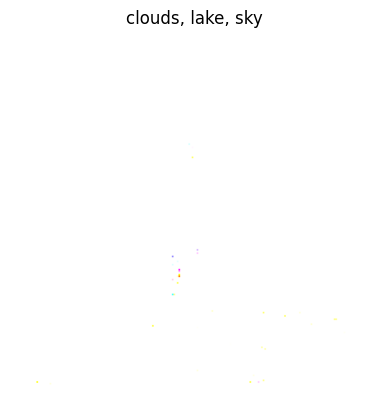

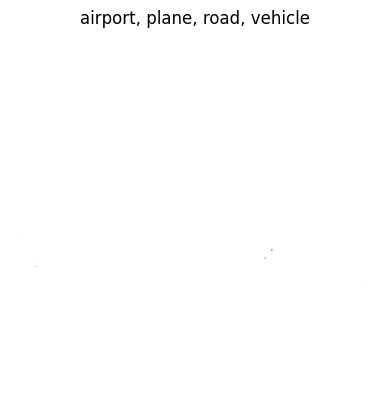

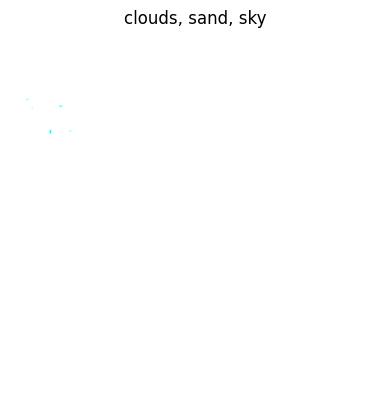

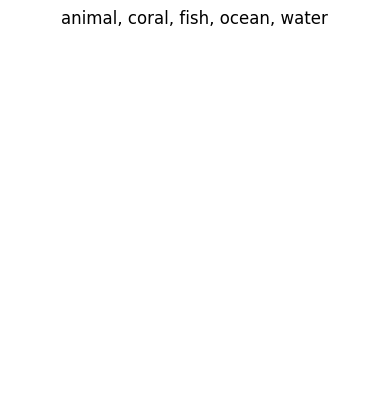

In [20]:
# Let's take a look at the data we have. To do it we need to load the dataset without augmentations.
dataset_val = NusDataset('./data/test.json', None)

# A simple function for visualization.
def show_sample(img, binary_img_labels):
    # Convert the binary labels back to the text representation.
    img_labels = np.array(dataset_val.classes)[np.argwhere(binary_img_labels > 0)[:, 0]]
    plt.imshow(img)
    plt.title("{}".format(', '.join(img_labels)))
    plt.axis('off')
    plt.show()

for sample_id in range(5):
    show_sample(*dataset_val[sample_id])

In [21]:
train_ds = NusDataset('./data/train.json')
val_ds = NusDataset('./data/val.json')
test_ds = NusDataset('./data/test.json')


train_dl = DataLoader(train_ds)
val_dl = DataLoader(val_ds)
test_dl = DataLoader(test_ds)

loading ./data/train.json
loading ./data/val.json
loading ./data/test.json


In [22]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # On retire les dernières couches avec "include_top=False"
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # "Glace" the paramètres pré-entrainés
    model.trainable = False

    # On rajoute les couches retirées - ces couches sont entrainables !
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)

    # On peut ajuster le ratio de neurones désactivés pour la couche Dropout
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation='sigmoid', name="predictions")(x)

    # Compile le nouveau modèle
    model = keras.Model(inputs, outputs, name="EfficientNet")

    # On augmente le learning rate du défaut 0.001 à 0.01
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)

    model.compile(
         optimizer=optimizer,
         loss=tf.keras.metrics.binary_crossentropy,
         metrics=["binary_accuracy"]
    )
    return model

In [23]:
NUM_CLASSES = 81
IMG_SIZE = 224
model = build_model(NUM_CLASSES)

In [24]:
def unfreeze_model(model):
    # On rends entrainable les derniers 20 layers (sauf ceux de BatchNormalization)
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
          layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss=tf.keras.metrics.binary_crossentropy, metrics=["binary_accuracy"]
    )


unfreeze_model(model)

In [8]:
!pip list| grep keras

keras                            3.4.1
tf_keras                         2.15.1


In [25]:
history = model.fit(x=train_dl,validation_data=val_dl,epochs=1)
model.save('simple_model.keras')

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 566s 225ms/step - binary_accuracy: 0.7982 - loss: 0.4038 - val_binary_accuracy: 0.9753 - val_loss: 0.0942


In [ ]:
model = keras.saving.load_model('simple_model.keras')
model.evaluate(x=test_dl)

loading ./data/test.json
0


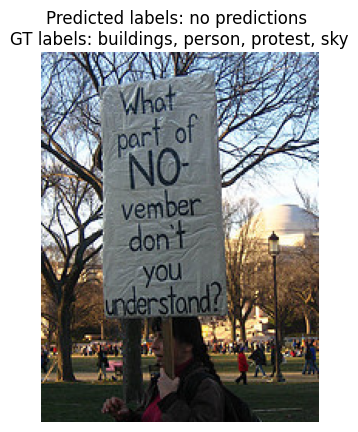

1


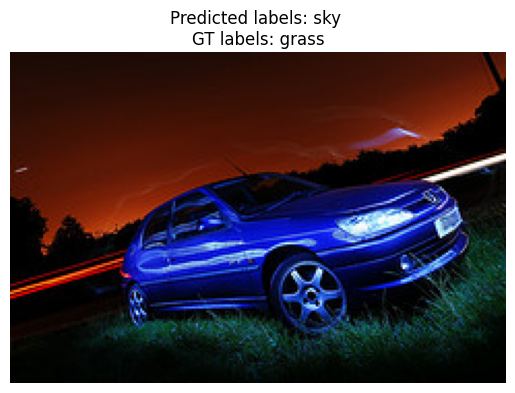

1


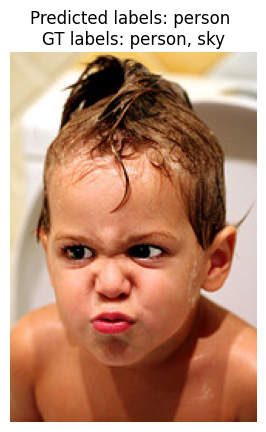

0


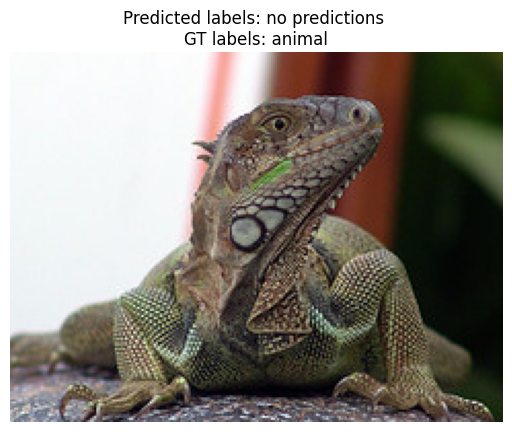

1


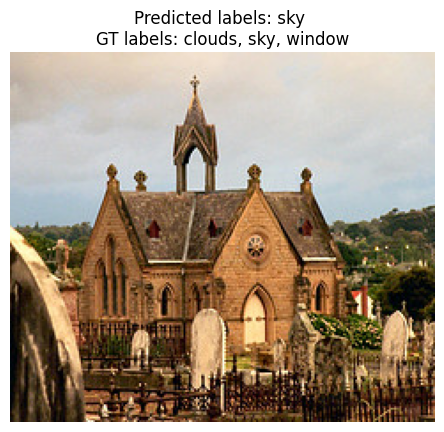

1


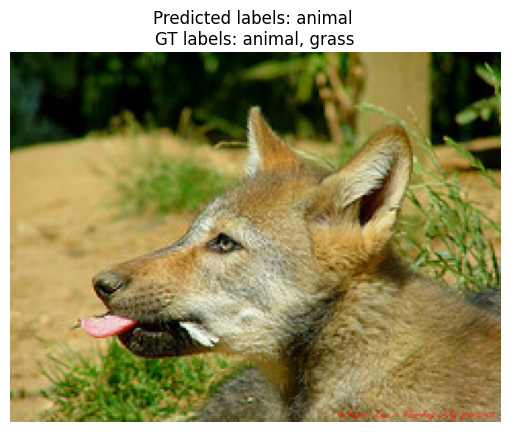

3


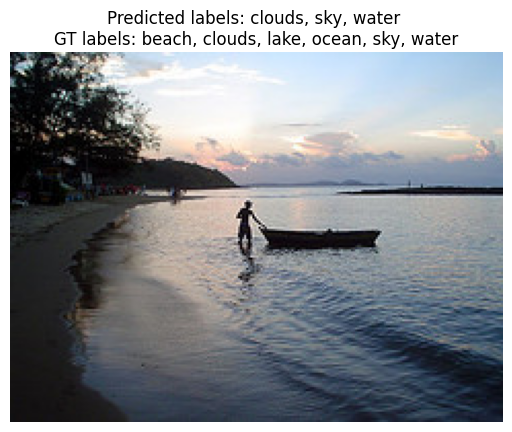

1


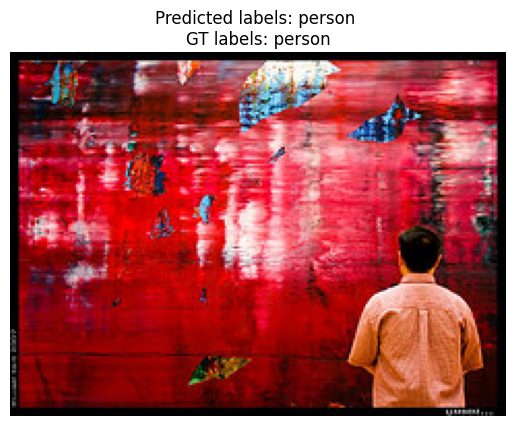

0


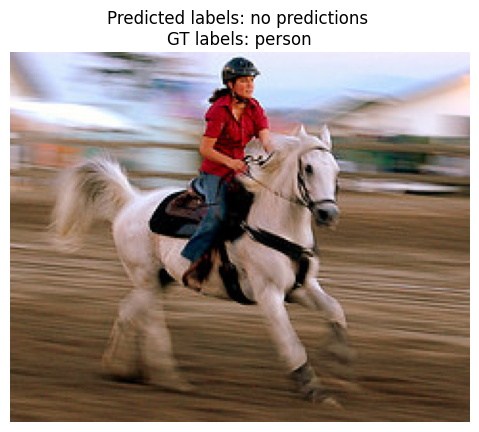

1


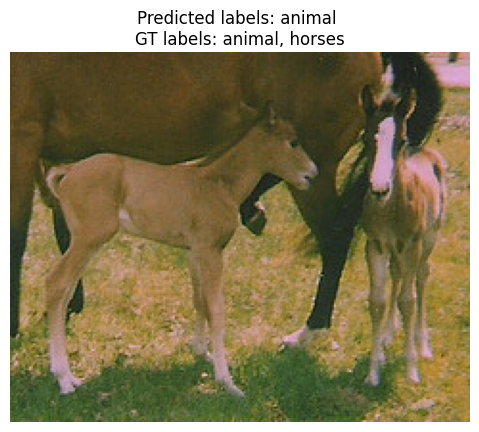

In [30]:
# Run inference on the test data
test_ds = NusDataset('./data/test.json')
for sample_id in range(5, 15):
    test_img, test_labels = test_ds[sample_id]
    test_img_path = test_ds.imgs[sample_id]
    test_img = np.expand_dims(test_img, axis=0)
    # raw_pred  = model(test_img, training = False)[0]
    raw_pred = model(test_img, training = False).cpu()[0]
    raw_pred = np.array(raw_pred > 0.5, dtype=float)

    predicted_labels = np.array(test_ds.classes)[np.argwhere(raw_pred > 0)[:, 0]]
    print(len(predicted_labels))
    if not len(predicted_labels):
        predicted_labels = ['no predictions']
    img_labels = np.array(test_ds.classes)[np.argwhere(test_labels > 0)[:, 0]]
    plt.imshow(Image.open(test_img_path))
    plt.title("Predicted labels: {} \nGT labels: {}".format(', '.join(predicted_labels), ', '.join(img_labels)))
    plt.axis('off')
    plt.show()